# Предсказание температуры стали

**Цель проекта:**
Оптимизировать производственные расходы, металлургического комбината путем уменьшения потребление электроэнергии на этапе обработки стали. 

Необходимо проанализировать данные и построить модель, которая предскажет температуру стали.


**Описание данных**

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` — данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

**План работы над проектом:**

1. *Подготовить данные:*
     - Загрузка данных 
     - Общая информация о объектах в датасетах.
     - Проверить данные на налиие пропусков, дублкатов и анномалий
     
     
2. *Провести исследовательский анализ данных*:
     - Анализ всего процесса обработки на примере 1 партии стали (key)
     - Общий анализ данных в датасетах основных статистических показателей     
     - Проведем анализ основных характеристик температуры (target) ее распределения и изменения.
     

3. *Провести предобработку данных*
    - Удалить анномалии и лишнии пропуски
    - Привести типы данных в столбцах в требуемы  для дальнейшей работы типы данных
     
 
4. *Формирование датасета для обучения моделей из исходных данных*
    - Отбор и создание признаков для обучения моделей (features selections)
    - Группировка датасетов по номеру партии
    - Соеденение выбранных признаков в один датасет
    - Подготовка признаков для обучении моделей
    - Поделить датасет на тестовую и тренировочную выборки
    
    
5. *Построить и обучить модель:*
     - Определение метрики для оценки модели 
     - Подобрать параметры и обучить разные модели, и оценить их качество на тренировочных данных с помощью определенной метрики
     - Выбрать модель для предсказани температуры, с лучшими итоговыми метриками
     - Оценить качество работы выбраной модели на тестовой выборке.



## Подготовка данных

### Импорт библиотек, настройки и константы

In [2]:
import pandas as pd
import numpy as np
import glob
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_selection import mutual_info_regression, SelectKBest
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor


from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout

2023-02-22 15:41:32.276885: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-22 15:41:32.606601: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-22 15:41:32.677217: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-22 15:41:32.677243: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

In [3]:
#настройки отображения информации
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)
pd.set_option('display.precision', 3)
pd.options.mode.chained_assignment = None 

In [4]:
#константа
STATE = np.random.RandomState(13022023)
np.random.seed(13022023)

### Загрузка данных и просмотр общей информации

In [5]:
try:
    path_names = sorted(glob.glob('data/*.csv'))
    data_arc, data_bulk, data_bulk_time, data_gas, data_temp, data_wire, data_wire_time = \
        (pd.read_csv(path) for path in path_names)
except:
    path_names = sorted(glob.glob('/datasets/final_steel/*.csv'))
    data_arc, data_bulk, data_bulk_time, data_gas, data_temp, data_wire, data_wire_time = \
        (pd.read_csv(path) for path in path_names)
path_names

['data/data_arc.csv',
 'data/data_bulk.csv',
 'data/data_bulk_time.csv',
 'data/data_gas.csv',
 'data/data_temp.csv',
 'data/data_wire.csv',
 'data/data_wire_time.csv']

In [6]:
data_list = [data_arc, data_bulk, data_bulk_time, data_gas, data_temp, data_wire, data_wire_time]

In [7]:
for i, val in enumerate(path_names):
    data_list[i].name = val.partition('/')[2].split('.')[0]
    
display([f'{data.name} - {data.shape}' for data in data_list])

['data_arc - (14876, 5)',
 'data_bulk - (3129, 16)',
 'data_bulk_time - (3129, 16)',
 'data_gas - (3239, 2)',
 'data_temp - (15907, 3)',
 'data_wire - (3081, 10)',
 'data_wire_time - (3081, 10)']

Датасеты разные, отличаются количеством объектов и количеством признаков в данных об электродах и в данных о замерах температуры примерно одинаковое количество объектов, в данных о подаче сыпучих материалов и проволочных примерно одинаковое количество. 

In [8]:
for data in data_list:
    print('\033[1m', f'Датасет {data.name}:', '\033[0m')  
    display(data.head())
    display(data.info())

 Датасет data_arc: 


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976,0.687
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.806,0.520
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744,0.499
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659,1.063
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.693,0.414


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


None

 Датасет data_bulk: 


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


None

 Датасет data_bulk_time: 


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


None

 Датасет data_gas: 


,key,Газ 1
0,1,29.750
1,2,12.556
2,3,28.555
3,4,18.841
4,5,5.414


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


None

 Датасет data_temp: 


,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


None

 Датасет data_wire: 


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.060,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.064,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238,9.115,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


None

 Датасет data_wire_time: 


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


None

Данные в таблицах имеют временные рамки, скорее всего порядок выполнения по техноологическому процесу. В данных `data_bulk`, `data_bulk_time`, `data_temp`, `data_wire`, `data_wire_time` имеются пропуски.
Судя по всему данные в таблицах `data_bulk`, `data_bulk_time` и `data_wire`, `data_wire_time` связанны тем, что в одной таблице количественные данные в другой время подачи.

In [9]:
#переименуем столбцы в соотвествии со snake_case
data_list[0].columns = ['key', 'start_arc_heating', 'end_arc_heating', 'active_power', 'reactive_power']
data_list[3].columns = ['key', 'gas_1']
data_list[4].columns = ['key', 'time_control', 'temperature']

for i in [1, 2, 5, 6]:
    data_list[i].columns = [f'{i.split(" ")[0].lower()}_{i.split(" ")[1]}'
                            if len(i.split(' ')) > 1 else i for i in data_list[i]]

In [10]:
#пустые значения и проверка исправления наименование признаков
for data in data_list:
    print('\033[1m', f'{data.name}:', '\033[0m')
    display(data.isna().sum().to_frame().T)
    print()

 data_arc: 


,key,start_arc_heating,end_arc_heating,active_power,reactive_power
0,0,0,0,0,0



 data_bulk: 


,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,0,2877,3107,1831,2115,3052,2553,3104,3128,3110,2953,2952,679,3111,323,881



 data_bulk_time: 


,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,0,2877,3107,1831,2115,3052,2553,3104,3128,3110,2953,2952,679,3111,323,881



 data_gas: 


,key,gas_1
0,0,0



 data_temp: 


,key,time_control,temperature
0,0,0,2901



 data_wire: 


,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,0,26,2002,3018,3067,3080,3008,3070,3062,3052



 data_wire_time: 


,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,0,26,2002,3018,3067,3080,3008,3070,3062,3052


Пропуски в большом количестве в таблицах `data_bulk`, `data_bulk_time`, `data_wire`, `data_wire_time` в повторяющемся количестве, скорее всего связанные с процессом обработки. Пропуски в `data_temp` необходимо будет исследовать более тщательно.

In [11]:
for data in data_list:
    print(f'{data.name} - {len(data.key.unique())} уникальных партий (key)')

data_arc - 3214 уникальных партий (key)
data_bulk - 3129 уникальных партий (key)
data_bulk_time - 3129 уникальных партий (key)
data_gas - 3239 уникальных партий (key)
data_temp - 3216 уникальных партий (key)
data_wire - 3081 уникальных партий (key)
data_wire_time - 3081 уникальных партий (key)


Уникальных партий в таблицах разное количество, самое большое количсетво в таблице `data_gas`, в обучении моелей будем использовать только полные партии, т.е. присутвующие во всех таблицах процесса.   

Тип дат имеет формат строки, изменим на формат дат для удобства дальнейшего анализа.

In [12]:
#изменим тип дат
data_list[0][['start_arc_heating', 'end_arc_heating']] = \
    data_list[0][['start_arc_heating', 'end_arc_heating']].astype('datetime64[ns]')

data_list[2][data_list[2].drop('key', axis=1).columns] = \
    data_list[2][data_list[2].drop('key', axis=1).columns].astype('datetime64[ns]')

data_list[4].time_control = data_list[4].time_control.astype('datetime64[ns]')

data_list[6][data_list[6].drop('key', axis=1).columns] = \
    data_list[6][data_list[6].drop('key', axis=1).columns].astype('datetime64[ns]')

In [13]:
#проверим 1 на выбор
data_list[6].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   key     3081 non-null   int64         
 1   wire_1  3055 non-null   datetime64[ns]
 2   wire_2  1079 non-null   datetime64[ns]
 3   wire_3  63 non-null     datetime64[ns]
 4   wire_4  14 non-null     datetime64[ns]
 5   wire_5  1 non-null      datetime64[ns]
 6   wire_6  73 non-null     datetime64[ns]
 7   wire_7  11 non-null     datetime64[ns]
 8   wire_8  19 non-null     datetime64[ns]
 9   wire_9  29 non-null     datetime64[ns]
dtypes: datetime64[ns](9), int64(1)
memory usage: 240.8 KB


In [14]:
#Проверим на наличие дубликатов
for data in data_list:
    print(f'{data.name} - {data.duplicated().sum()} дубликатов')

data_arc - 0 дубликатов
data_bulk - 0 дубликатов
data_bulk_time - 0 дубликатов
data_gas - 0 дубликатов
data_temp - 0 дубликатов
data_wire - 0 дубликатов
data_wire_time - 0 дубликатов


Явных дубликатов в таблицах нет

## Исследовательский анализ данных

### Анализ процесса обработки одной партии

In [15]:
#выбираем случайный номер партии
random_batch_num = 15

In [16]:
for data in data_list:
    print('\033[1m', f'Процесс {data.name}:', '\033[0m')
    display(data.query('key == @random_batch_num'))

 Процесс data_arc: 


,key,start_arc_heating,end_arc_heating,active_power,reactive_power
66,15,2019-05-03 20:53:55,2019-05-03 20:57:01,0.591,0.465
67,15,2019-05-03 21:01:03,2019-05-03 21:03:59,0.573,0.499
68,15,2019-05-03 21:08:33,2019-05-03 21:11:18,0.550,0.402
69,15,2019-05-03 21:11:52,2019-05-03 21:13:31,0.320,0.243
70,15,2019-05-03 21:29:02,2019-05-03 21:30:30,0.317,0.224


 Процесс data_bulk: 


,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
14,15,NaN,NaN,NaN,NaN,NaN,77.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,251.0,203.0


 Процесс data_bulk_time: 


,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
14,15,NaT,NaT,NaT,NaT,NaT,2019-05-03 21:15:20,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 21:03:07,2019-05-03 21:03:07


 Процесс data_gas: 


,key,gas_1
14,15,11.085


 Процесс data_temp: 


,key,time_control,temperature
72,15,2019-05-03 20:58:40,1605.0
73,15,2019-05-03 20:59:18,1607.0
74,15,2019-05-03 21:16:15,1611.0
75,15,2019-05-03 21:23:23,1613.0
76,15,2019-05-03 21:23:54,1599.0
77,15,2019-05-03 21:33:01,1598.0


 Процесс data_wire: 


,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
14,15,71.286,52.096,NaN,NaN,NaN,NaN,NaN,NaN,NaN


 Процесс data_wire_time: 


,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
14,15,2019-05-03 21:07:40,2019-05-03 21:15:12,NaT,NaT,NaT,NaT,NaT,NaT,NaT


**Технологический процесс 1 партии:**  
- `20:53:55` - начало нагрева дуги 1 итерации
- `20:57:01` - конец нагрева дуги 1 итерации
- `20:58:40` - результаты замера температуры после 1 итерации
- *обработка энертным газом, и перемешивание*
- `20:59:18` - результаты замера температуры после нагревания и обработки газом и перемешиванием
- `21:01:03` - начало нагрева дуги 2 итерации
- `21:03:07` - добавление Bulk 14
- `21:03:07` - добавление Bulk 15
- `21:03:59` - конец нагрева дуги 2 итераци
- `21:07:40` - добавление Wire 1
- `21:08:33` - начало нагрева дуги 3 итерации
- `21:11:18` - конец нагрева дуги 3 итерации
- `21:11:52` - начало нагрева дуги 4 итерации
- `21:13:31` - конец нагрева дуги 4 итерации
- `21:15:12` - добавление Wire 2
- `21:15:20` - добавление Bulk 6
- `21:16:15` - результаты замера температуры после 4 итерации
- `21:23:23` - результаты замера температуры 
- `21:23:54` - результаты замера температуры 
- `21:29:02` - начало нагрева дуги 5 итерации
- `21:30:30` - конец нагрева дуги 5 итерации
- `21:33:01` - заключительный результат замера температуры после 5 итерации  

Судя по технологическому процессу обработки стали пропуски в таблицах `data_bulk`, `data_bulk_time` и `data_wire`, `data_wire_time` связаны с осбенностями процесса в частности с подачей или не подачей того или иного концентрата или проволки. В данной партии температура постоянно меняестя то в сторону повышения,то понижения. Темперетура зависит от активной и реактивной мощности, с их уменьшением или увеличением изменяется температура.

Так же необходимо будет учитывать, что по времени таблицы рассинхронированы, и не соответствуют друг другу. Использовать временные интервалы будем только 

### Общий анализ данных в датасетах основных статистических показателей

In [17]:
def plot_helper(data, bins=15, x_title='', y_title='', title='', type_plot='hist'): 
    if type_plot == 'hist':
        plt.hist(data, bins=bins)
    elif type_plot == 'boxplot':
        plt.boxplot(data, vert=False)
    elif type_plot == 'scatter':
        plt.scatter(data.key, data.temperature, marker="d", alpha=0.5)
    elif type_plot == 'bar':
        data.plot(kind='bar', rot=60)
    elif type_plot == 'plot':
        plt.plot(data.loss.loc[5:], label='loss')
        plt.plot(data.val_loss.loc[5:], label='val_loss')
        plt.xlabel(x_title)
        plt.ylabel(y_title)
        plt.legend()
    elif type_plot == 'line':
        data.plot(kind='line', rot=40)
        plt.legend()
    else:
        print('ОШИБКА: Некоректный тип графика')
        
    plt.xlabel(x_title)
    plt.ylabel(y_title)
    plt.title(title, fontweight='bold')
    plt.grid(True)

In [18]:
for data in data_list:
    print('\033[1m', f'{data.name}:', '\033[0m')
    display(data.describe())
    print()

 data_arc: 


,key,active_power,reactive_power
count,14876.000,14876.000,14876.000
mean,1615.220,0.670,0.453
std,934.572,0.408,5.879
min,1.000,0.030,-715.505
25%,806.000,0.395,0.291
50%,1617.000,0.556,0.416
75%,2429.000,0.857,0.637
max,3241.000,3.732,2.676



 data_bulk: 


,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
count,3129.000,252.000,22.000,1298.000,1014.000,77.000,576.000,25.000,1.0,19.000,176.000,177.000,2450.000,18.000,2806.000,2248.000
mean,1624.384,39.242,253.045,113.879,104.394,107.026,118.925,305.600,49.0,76.316,83.284,76.819,260.471,181.111,170.285,160.513
std,933.338,18.278,21.181,75.483,48.184,81.791,72.058,191.023,NaN,21.721,26.060,59.655,120.649,46.088,65.869,51.765
min,1.000,10.000,228.000,6.000,12.000,11.000,17.000,47.000,49.0,63.000,24.000,8.000,53.000,151.000,16.000,1.000
25%,816.000,27.000,242.000,58.000,72.000,70.000,69.750,155.000,49.0,66.000,64.000,25.000,204.000,153.250,119.000,105.000
50%,1622.000,31.000,251.500,97.500,102.000,86.000,100.000,298.000,49.0,68.000,86.500,64.000,208.000,155.500,151.000,160.000
75%,2431.000,46.000,257.750,152.000,133.000,132.000,157.000,406.000,49.0,70.500,102.000,106.000,316.000,203.500,205.750,205.000
max,3241.000,185.000,325.000,454.000,281.000,603.000,503.000,772.000,49.0,147.000,159.000,313.000,1849.000,305.000,636.000,405.000



 data_bulk_time: 


,key
count,3129.000
mean,1624.384
std,933.338
min,1.000
25%,816.000
50%,1622.000
75%,2431.000
max,3241.000



 data_gas: 


,key,gas_1
count,3239.000,3239.000
mean,1621.861,11.002
std,935.386,6.220
min,1.000,0.008
25%,812.500,7.043
50%,1622.000,9.836
75%,2431.500,13.770
max,3241.000,77.995



 data_temp: 


,key,temperature
count,15907.000,13006.000
mean,1607.881,1591.841
std,942.212,21.376
min,1.000,1191.000
25%,790.000,1581.000
50%,1618.000,1591.000
75%,2427.000,1601.000
max,3241.000,1705.000



 data_wire: 


,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
count,3081.000,3055.000,1079.000,63.000,14.000,1.000,73.000,11.000,19.000,29.000
mean,1623.426,100.896,50.577,189.483,57.443,15.132,48.017,10.039,53.625,34.156
std,932.997,42.013,39.320,99.513,28.825,NaN,33.920,8.611,16.882,19.932
min,1.000,1.919,0.030,0.144,24.149,15.132,0.034,0.234,45.077,4.623
25%,823.000,72.116,20.194,95.135,40.807,15.132,25.054,6.763,46.095,22.058
50%,1619.000,100.158,40.143,235.195,45.234,15.132,42.076,9.017,46.280,30.066
75%,2434.000,126.060,70.228,276.252,76.125,15.132,64.213,11.886,48.090,43.862
max,3241.000,330.314,282.780,385.009,113.231,15.132,180.455,32.848,102.762,90.054



 data_wire_time: 


,key
count,3081.000
mean,1623.426
std,932.997
min,1.000
25%,823.000
50%,1619.000
75%,2434.000
max,3241.000


- в таблице `data_arc` явно бросается в глаза минимум в столбце reactive_power -715,505, скорее всего аномалия
-  в некоторых признаках таблицы `data_bulk` и `data_wire`, очень маленькое количество участий в процессе/
- в таблице `data_temp` есть аномально низкие температуры менее 1400 (нормальная температура плавления 1300-1500 гралусов по Цельсию)

In [19]:
#таблица max min mean мощностей
group_power = data_list[0].groupby('key').agg({'active_power' : ['min', 'max', 'mean'], 
                                               'reactive_power' : ['min', 'max', 'mean']})
group_power.head()

active_power               reactive_power              
             min    max   mean            min    max   mean
key                                                        
1          0.693  1.659  0.976          0.414  1.063  0.637
2          0.438  1.296  0.763          0.283  0.893  0.500
3          0.250  1.062  0.505          0.156  0.671  0.320
4          0.426  1.221  0.802          0.268  0.755  0.515
5          0.267  1.622  0.837          0.182  1.048  0.563

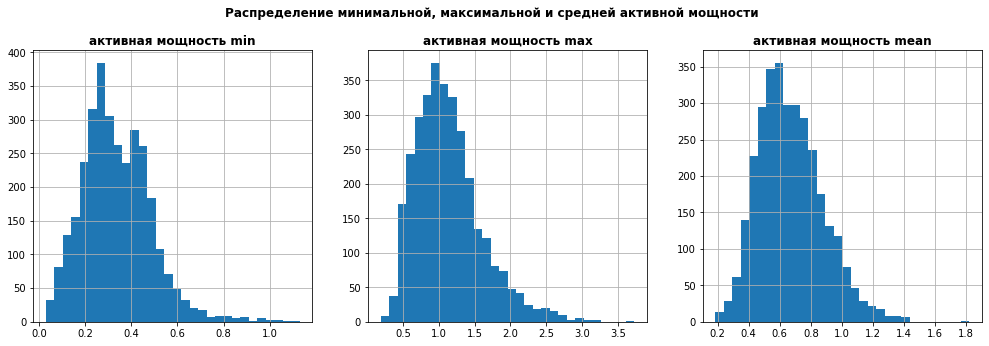

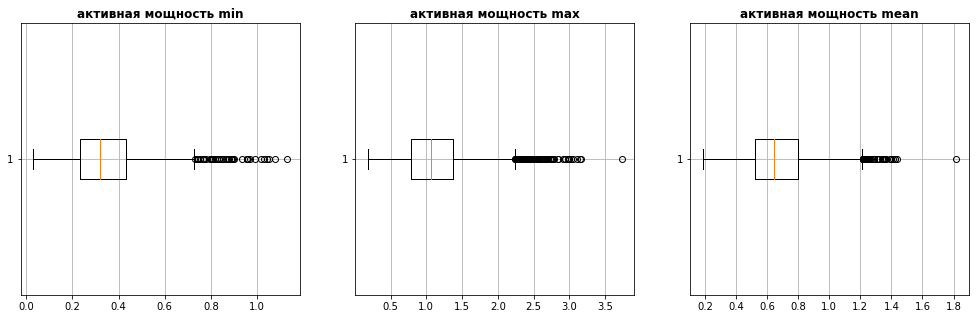

In [20]:
ax = [131, 132, 133]
plt.figure(figsize = (17, 5))
plt.suptitle('Распределение минимальной, максимальной и средней активной мощности', 
             fontsize = 12, fontweight='bold', y = 1.)
for i, col in enumerate(['min', 'max', 'mean']):
    plt.subplot(ax[i])
    plot_helper(group_power.active_power[[col]], bins=30, title=f'активная мощность {col}')
plt.show()

plt.figure(figsize = (17, 5))
for i, col in enumerate(['min', 'max', 'mean']):
    plt.subplot(ax[i])
    plot_helper(group_power.active_power[[col]], title=f'активная мощность {col}', type_plot='boxplot')
plt.show()

Распределение автивной мощности, нрмальное скошенное в право, при этапе и максимальная и минимальная и средняя мощности показывают наличие выбивающихся из общей статистики мощности.

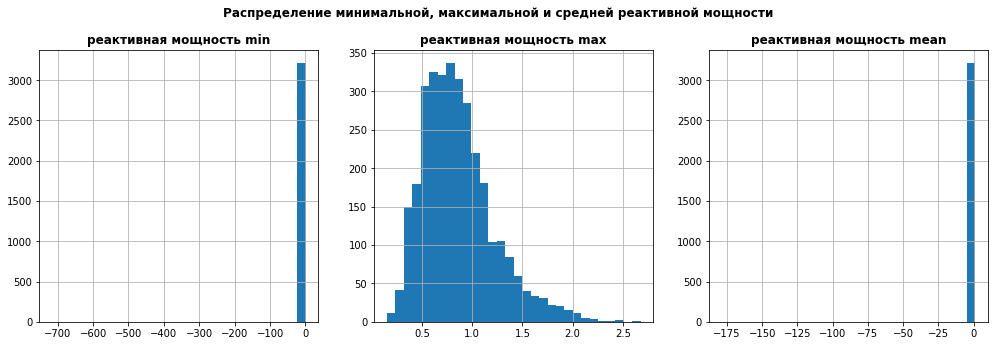

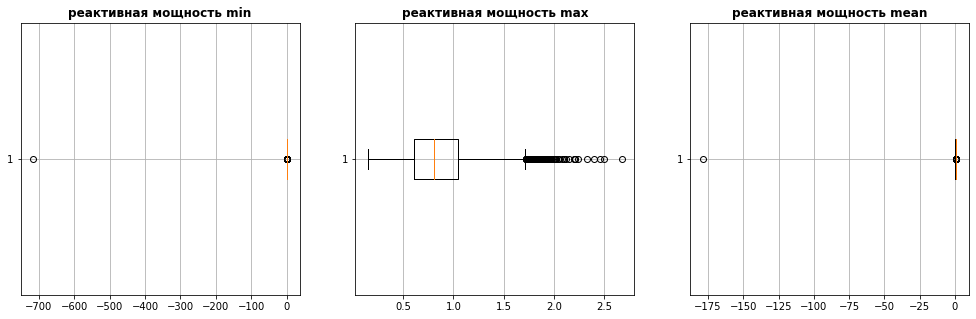

In [21]:
ax = [131, 132, 133]
plt.figure(figsize = (17, 5))
plt.suptitle('Распределение минимальной, максимальной и средней реактивной мощности', 
             fontsize = 12, fontweight='bold', y = 1.)
for i, col in enumerate(['min', 'max', 'mean']):
    plt.subplot(ax[i])
    plot_helper(group_power.reactive_power[[col]], bins=30, title=f'реактивная мощность {col}')
plt.show()

plt.figure(figsize = (17, 5))
for i, col in enumerate(['min', 'max', 'mean']):
    plt.subplot(ax[i])
    plot_helper(group_power.reactive_power[[col]], title=f'реактивная мощность {col}', type_plot='boxplot')
plt.show()

В реактивной мощности мы наблюдаем отмеченный выше выброс на минимальных и средних значениях. Данная аномалия искажает реальное отображения статистикии необходимо ее удалить. Максимальные значения не искажены аномалией и отображают такю же тенденцию нормального распределения со скошеным в право хвостом.

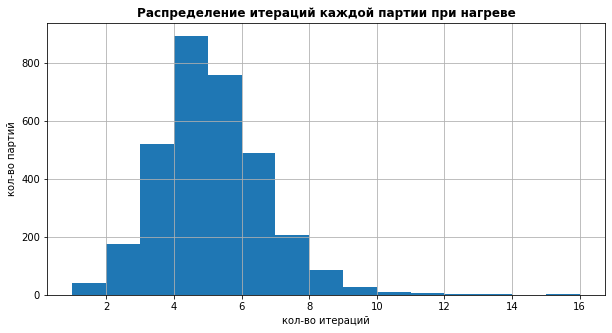

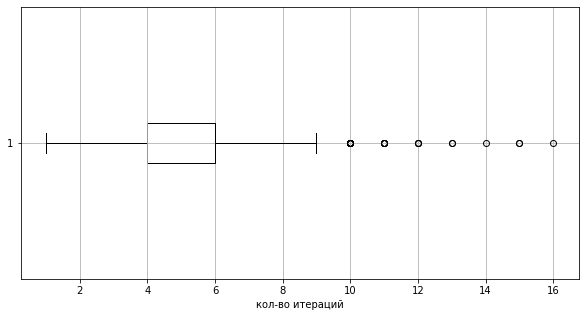

In [22]:
#Количество итераций и количество партий 
plt.figure(figsize = (10, 5))
plot_helper(data_list[0].key.value_counts(), 
            x_title='кол-во итераций',
            y_title='кол-во партий',
            title='Распределение итераций каждой партии при нагреве', 
            bins=15)
plt.show()

plt.figure(figsize = (10, 5))
plot_helper(data_list[0].key.value_counts(), x_title='кол-во итераций', type_plot='boxplot')
plt.show()

Основное количество итераций в партии от 1 до 9, но так же имеются значения выще 3 квантиля , до максимальных 16 итераций

In [23]:
group_temperature = data_list[4].groupby('key').agg({'temperature' : ['min', 'max', 'mean']})
group_temperature.head()

temperature                  
            min     max      mean
key                              
1        1571.0  1618.0  1601.400
2        1577.0  1608.0  1593.500
3        1596.0  1599.0  1597.800
4        1601.0  1625.0  1616.333
5        1576.0  1602.0  1589.000

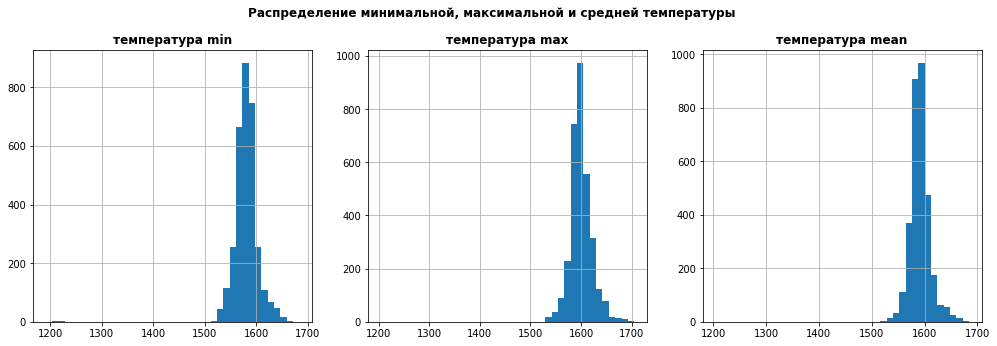

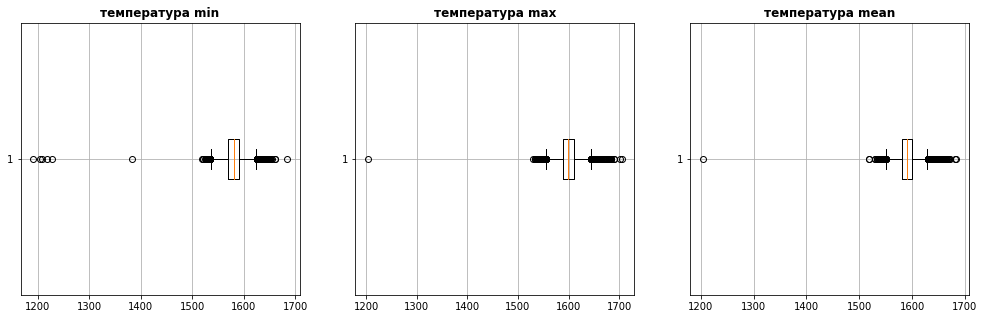

In [24]:
ax = [131, 132, 133]
plt.figure(figsize = (17, 5))
plt.suptitle('Распределение минимальной, максимальной и средней температуры', 
             fontsize = 12, fontweight='bold', y = 1.)
for i, col in enumerate(['min', 'max', 'mean']):
    plt.subplot(ax[i])
    plot_helper(group_temperature.temperature[[col]], title=f'температура {col}', bins=40)
plt.show()

plt.figure(figsize = (17, 5))
for i, col in enumerate(['min', 'max', 'mean']):
    plt.subplot(ax[i])
    plot_helper(group_temperature.temperature[[col]], title=f'температура {col}', type_plot='boxplot')
plt.show()

Распределение температуры нормальное, явно налюдаются аномально низкие для плавления стали температуры, менее 1400 градусов.

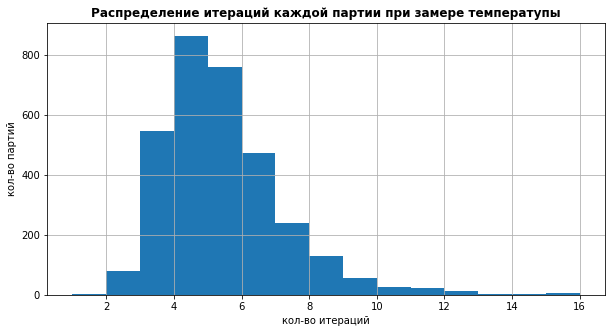

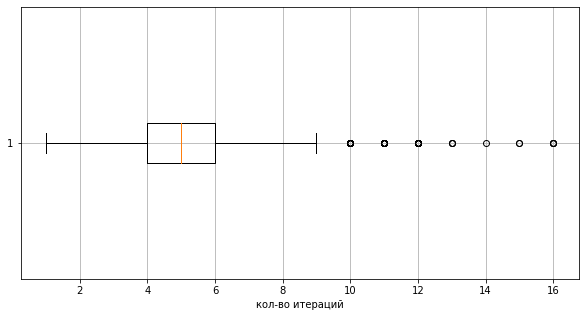

In [25]:
#количество партий и итерации при замере температуры
plt.figure(figsize = (10, 5))
plot_helper(data_list[4].key.value_counts(), 
            x_title='кол-во итераций',
            y_title='кол-во партий',
            title='Распределение итераций каждой партии при замере температупы', 
            bins=15)
plt.show()

plt.figure(figsize = (10, 5))
plot_helper(data_list[4].key.value_counts(), x_title='кол-во итераций', type_plot='boxplot')
plt.show()

Рапсределение количества итерраций в каждой партии примерно такое же как в таблице нагрева электродов, основном от 1 до 9 со значениями выше 3 квантиля до 17 итераций. Это и логично, самая высокая кореляция температуры будет с данными по нагреванию электродов. 

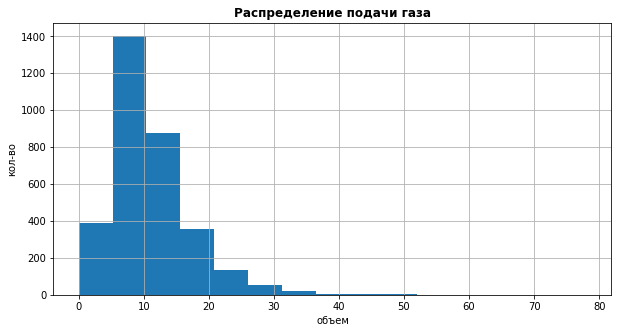

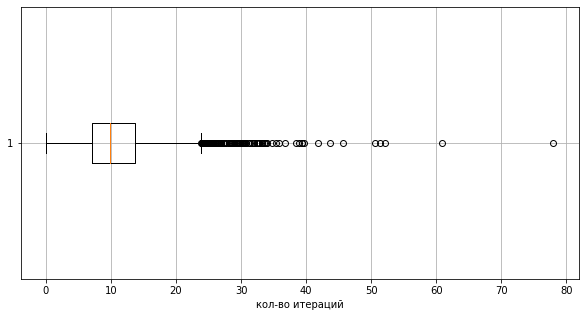

In [26]:
#распределение газа
plt.figure(figsize = (10, 5))
plot_helper(data_list[3].gas_1, 
            x_title='объем',
            y_title='кол-во',
            title='Распределение подачи газа', 
            bins=15)
plt.show()

plt.figure(figsize = (10, 5))
plot_helper(data_list[3].gas_1, x_title='кол-во итераций', type_plot='boxplot')
plt.show()

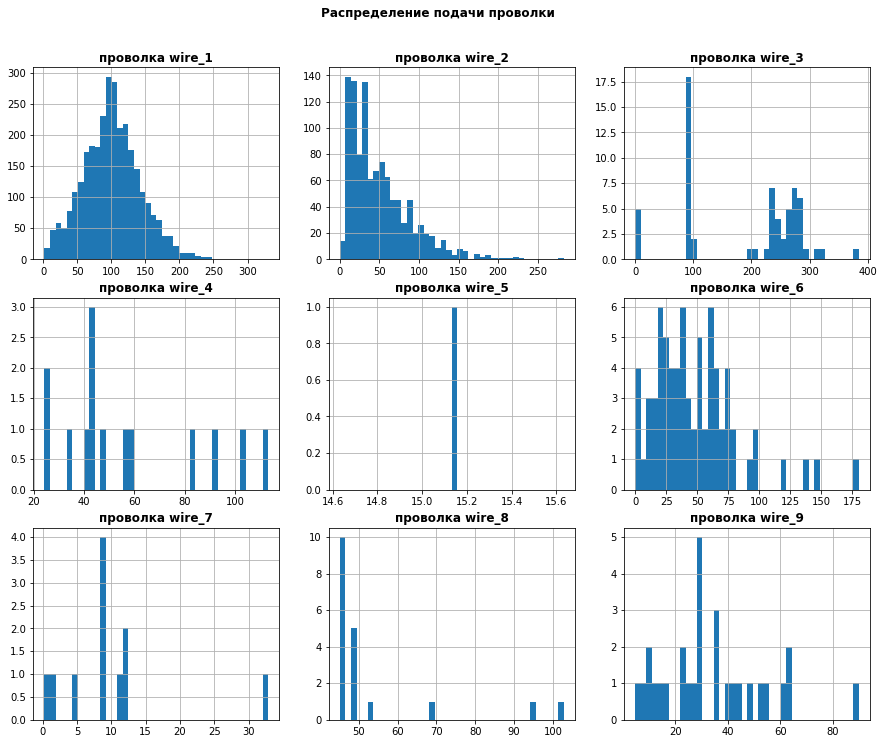

In [27]:
#Проволка
ax = [331, 332, 333, 334, 335, 336, 337, 338, 339]
plt.figure(figsize = (15, 12))
plt.suptitle('Распределение подачи проволки', 
             fontsize = 12, fontweight='bold', y = .95)
for i, col in enumerate(data_list[5].drop('key', axis=1).columns):
    plt.subplot(ax[i])
    plot_helper(data_list[5][col], title=f'проволка {col}', bins=40)
plt.show()


Визуализация рапределения подтверждает факт, что некоторые виды проволки, не обладают достаточным количеством участия в процессе и их следует исключить из выборки.

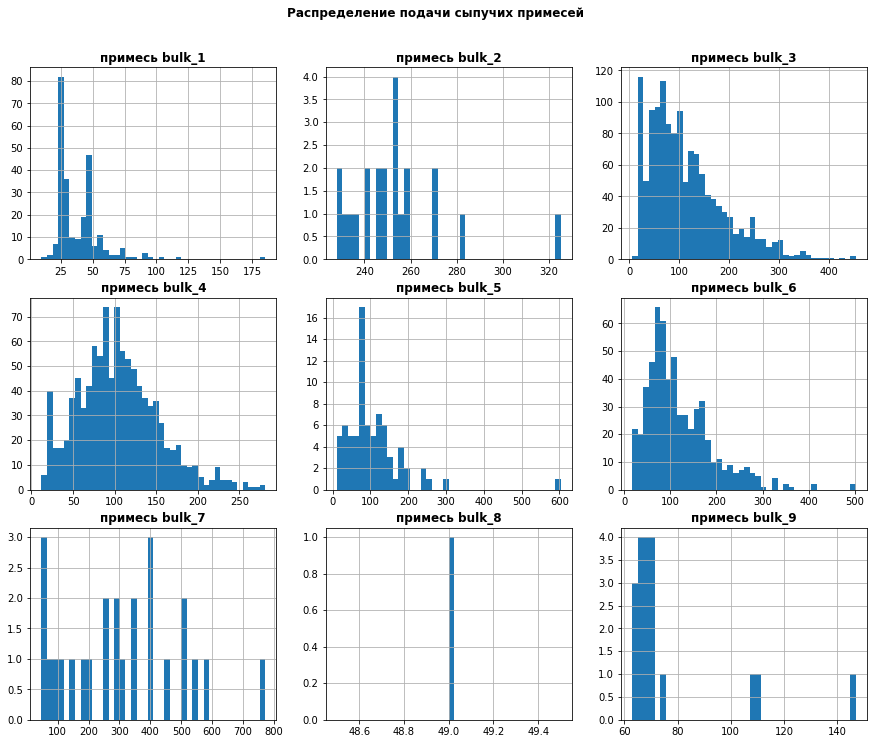

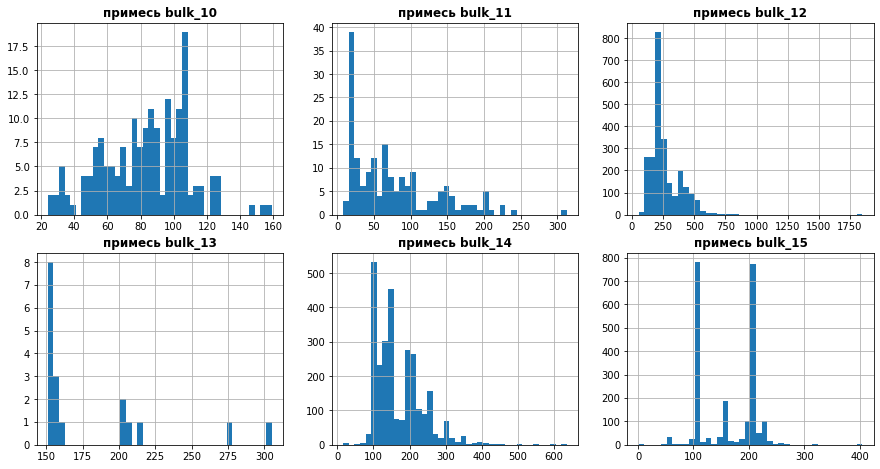

In [28]:
#Сыпучие материалы
ax = [331, 332, 333, 334, 335, 336, 337, 338, 339]
plt.figure(figsize = (15, 12))
plt.suptitle('Распределение подачи сыпучих примесей', 
             fontsize = 12, fontweight='bold', y = .95)
for i, col in enumerate(data_list[1].drop('key', axis=1).columns[0:9]):
    plt.subplot(ax[i])
    plot_helper(data_list[1][col], title=f'примесь {col}', bins=40)
plt.show()
plt.figure(figsize = (15, 12))
for i, col in enumerate(data_list[1].drop('key', axis=1).columns[9:15]):
    plt.subplot(ax[i])
    plot_helper(data_list[1][col], title=f'примесь {col}', bins=40)
plt.show()


Визуализация подачи сыпучих примесей, так же подтверждает, наличие примесей с низким участием в процессе, которые необходимо будет удалить

### Анализ основных характеристик целевой температуры

In [29]:
#Выделение последнего замера температуры в тагрет
target = data_list[4].sort_values(by='time_control').drop_duplicates(subset=['key'], keep='last')
target.head()

,key,time_control,temperature
4,1,2019-05-03 11:30:39,1613.0
10,2,2019-05-03 11:59:12,1602.0
15,3,2019-05-03 12:34:57,1599.0
18,4,2019-05-03 12:59:25,1625.0
20,5,2019-05-03 13:36:01,1602.0


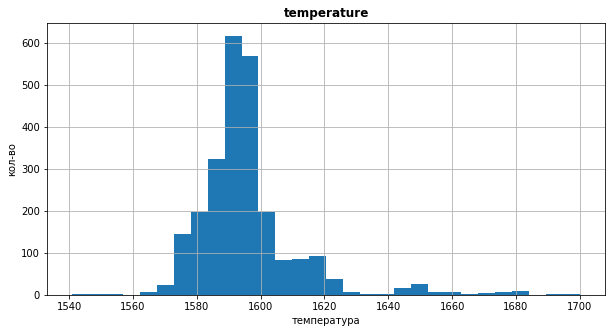

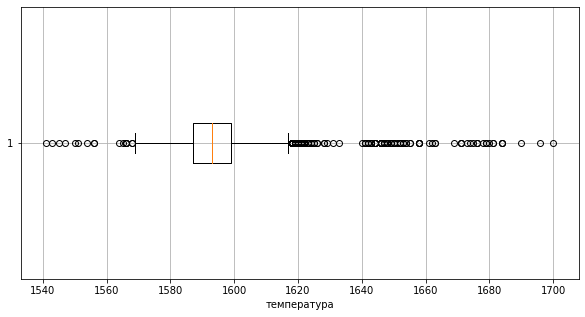

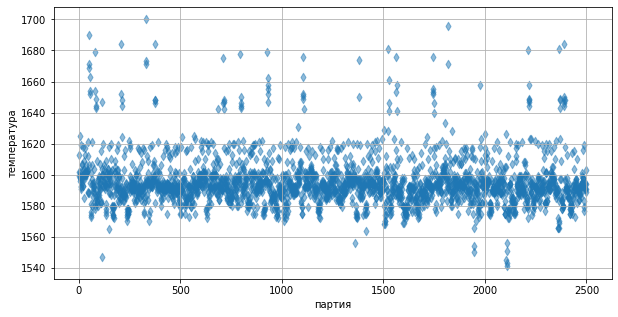

In [30]:
#распределение таргета
plt.figure(figsize = (10, 5))
plot_helper(target.temperature, x_title='температура', y_title='кол-во', title='temperature', bins=30)
plt.show()

plt.figure(figsize = (10, 5))
plot_helper(target.temperature.dropna(), x_title='температура', type_plot='boxplot')
plt.show()

plt.figure(figsize = (10, 5))
plot_helper(target, x_title='партия', y_title='температура', type_plot='scatter')
plt.show()

Визуализация финальных температур партий, отличается от графиков визализации максимальных температур партий, что говорит, о том, что финальные температуры не являются максимальными. В основном целевая температура варьируется от 1570 до 1600, но есть и аномально высокие температуры в районе 1700.

In [31]:
print('Количество пропусков -', target.temperature.isna().sum())
print('Уникальных партий в пропусках-', len(target[target.temperature.isna()].key.unique()))

Количество пропусков - 739
Уникальных партий в пропусках- 739


In [32]:
#5 случайных партий с пропусками
passes = target.loc[target.temperature.isna()].sample(5).key.values
data_list[4].query('key in @passes')

,key,time_control,temperature
13742,2796,2019-08-16 21:59:03,1629.0
13743,2796,2019-08-16 22:00:08,NaN
13744,2796,2019-08-16 22:15:04,NaN
13745,2796,2019-08-16 22:28:54,NaN
13746,2796,2019-08-16 22:38:25,NaN
13747,2796,2019-08-16 22:42:18,NaN
13984,2838,2019-08-18 08:39:03,1593.0
13985,2838,2019-08-18 08:54:24,NaN
13986,2838,2019-08-18 09:00:25,NaN
14912,3024,2019-08-25 02:10:48,1573.0


Пропуски в партиях значительные, данные не актуальные, исключим их их датасета.

## Отбор признаков и предобработка данных

### Отбор и создание признаков для обучения моделей (features selections)

Т.к. удалять и обрабатывать необходимо в разрезе партий, в начале с группируем таблицы и на генерируем фичи

In [33]:
df_energy = data_list[0].copy()
df_energy.tail()

,key,start_arc_heating,end_arc_heating,active_power,reactive_power
14871,3241,2019-09-01 03:58:58,2019-09-01 04:01:35,0.534,0.354
14872,3241,2019-09-01 04:05:04,2019-09-01 04:08:04,0.677,0.524
14873,3241,2019-09-01 04:16:41,2019-09-01 04:19:45,0.734,0.476
14874,3241,2019-09-01 04:31:51,2019-09-01 04:32:48,0.221,0.146
14875,3241,2019-09-01 04:34:47,2019-09-01 04:36:08,0.307,0.197


In [34]:
#Время нагревания
df_energy['time_heating'] = df_energy.end_arc_heating - df_energy.start_arc_heating 
df_energy['heating_minutes'] = df_energy.time_heating / np.timedelta64(1, 'm')
df_energy.head()


,key,start_arc_heating,end_arc_heating,active_power,reactive_power,time_heating,heating_minutes
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976,0.687,0 days 00:03:48,3.800
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.806,0.520,0 days 00:03:05,3.083
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744,0.499,0 days 00:02:52,2.867
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659,1.063,0 days 00:06:05,6.083
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.693,0.414,0 days 00:02:28,2.467


Расчитаем `полную мощность` и `коэфициент мощности` (`cosФ`) по формулам:

*Полная мощность = √ (Активная мощность2 + Реактивная мощность2)*  
*Коэффициент мощности = Активная мощность / Полная мощность*

In [35]:
#Полная мощность
df_energy['full_power'] = (df_energy.active_power**2 + df_energy.reactive_power**2)**.5
df_energy['k_power'] = df_energy.active_power / df_energy.full_power

Расчитаем `работу электрического тока (A)` для нагревания стали по формуле:

*A = Полная мощность x Время нагревания*  


In [36]:
df_energy['electric_work'] = df_energy.heating_minutes * df_energy.full_power
df_energy.sample(3)

,key,start_arc_heating,end_arc_heating,active_power,reactive_power,time_heating,heating_minutes,full_power,k_power,electric_work
11701,2552,2019-08-07 22:35:07,2019-08-07 22:37:56,0.677,0.470,0 days 00:02:49,2.817,0.824,0.822,2.322
666,144,2019-05-08 18:10:07,2019-05-08 18:13:15,0.716,0.470,0 days 00:03:08,3.133,0.856,0.836,2.683
11823,2570,2019-08-08 17:21:41,2019-08-08 17:23:21,0.254,0.236,0 days 00:01:40,1.667,0.347,0.732,0.578


In [37]:
#с группируем по номерам партий и отберем необходимые признаки
df_energy = df_energy.groupby('key').agg({'full_power' : 'sum', 
                                          'k_power' : 'mean', 
                                          'electric_work' : 'sum', 
                                          'heating_minutes' : ['sum', 'count']}).reset_index()
df_energy.columns = [i[0] if i[1] != 'count' else 'iterations' for i in df_energy.columns]
df_energy.sample(5)

,key,full_power,k_power,electric_work,heating_minutes,iterations
325,330,6.286,0.819,38.042,20.383,4
3008,3034,3.931,0.810,14.156,12.200,4
1174,1189,4.806,0.821,18.043,16.583,5
467,474,5.458,0.825,23.180,17.300,5
2062,2080,6.273,0.807,24.006,20.483,6


### Группировка данных и добавление признаков в один датасет

In [38]:
#первый замер температуры
df = data_list[4].sort_values(by='time_control', ascending=False).drop_duplicates(subset=['key'], keep='last')
df.columns = ['key', 'time_control', 'start_temperature'] 
df.head()

,key,time_control,start_temperature
15902,3241,2019-09-01 04:03:30,1586.0
15894,3240,2019-09-01 02:39:01,1617.0
15886,3239,2019-09-01 01:31:47,1598.0
15883,3238,2019-08-31 23:30:31,1584.0
15878,3237,2019-08-31 22:44:04,1569.0


In [39]:
#обработка газом
df = df[['key', 'start_temperature']].merge(data_list[3], how='inner', on='key')
df.sample(5)

,key,start_temperature,gas_1
726,2512,1574.0,6.692
1109,2123,1625.0,14.383
3173,43,1608.0,7.340
2293,934,1649.0,2.848
1515,1715,1583.0,6.865


In [40]:
#объеденим датасет
df = df.merge(df_energy, how='inner', on='key')
df.sample(3)

,key,start_temperature,gas_1,full_power,k_power,electric_work,heating_minutes,iterations
2881,337,1559.0,22.682,5.373,0.802,21.013,16.400,5
106,3133,1580.0,5.901,2.816,0.814,9.281,9.100,3
1148,2083,1587.0,7.533,4.460,0.782,19.461,16.667,6


In [41]:
df_bulk = data_list[1].copy()
df_bulk['total_bulk'] = df_bulk.apply(lambda x: x.notna().sum() - 1, axis=1)
df_bulk.head()

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,total_bulk
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0,4
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0,4
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0,4
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0,4
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0,4


In [42]:
df_wire = data_list[5].copy()
df_wire['total_wire'] = df_wire.apply(lambda x: x.notna().sum() - 1, axis=1)
df_wire.head()

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,total_wire
0,1,60.060,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,2,96.052,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,3,91.160,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,4,89.064,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4,5,89.238,9.115,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2


In [43]:
#добавим информацию по добавлению ресурсов
df = df.merge(df_bulk, how='inner', on='key')
df = df.merge(df_wire, how='inner', on='key')
df.sample(3)

,key,start_temperature,gas_1,full_power,k_power,electric_work,heating_minutes,iterations,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,total_bulk,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,total_wire
635,2557,1611.0,12.559,3.042,0.801,7.494,11.067,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,158.0,NaN,148.0,102.0,3,108.370,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1302,1841,1559.0,13.815,4.727,0.793,14.713,15.667,6,NaN,NaN,169.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,154.159,65.055,285.117,NaN,NaN,NaN,NaN,NaN,NaN,3
59,3178,1607.0,4.562,1.029,0.764,1.984,3.833,2,NaN,NaN,NaN,38.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,33.066,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [44]:
#добавим таргет
df = df.merge(target.drop('time_control', axis=1), how='inner', on='key')
df

,key,start_temperature,gas_1,full_power,k_power,electric_work,heating_minutes,iterations,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,total_bulk,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,total_wire,temperature
0,3241,1586.0,12.681,3.000,0.828,7.668,10.983,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,180.0,52.0,2,63.118,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN
1,3240,1617.0,11.863,3.892,0.776,12.153,13.983,5,NaN,NaN,NaN,NaN,NaN,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,192.0,54.0,3,34.070,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN
2,3239,1598.0,16.024,5.612,0.831,16.884,20.267,8,NaN,NaN,NaN,NaN,NaN,114.0,NaN,NaN,NaN,NaN,NaN,158.0,NaN,270.0,88.0,4,143.358,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN
3,3238,1584.0,6.746,2.697,0.782,9.264,9.100,3,NaN,NaN,126.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,254.0,NaN,108.0,106.0,4,56.129,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN
4,3237,1569.0,5.544,4.845,0.810,15.972,15.150,5,NaN,NaN,170.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,252.0,NaN,130.0,206.0,4,38.089,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3017,5,1576.0,5.414,4.036,0.828,19.986,14.483,4,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0,4,89.238,9.115,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,1602.0
3018,4,1601.0,18.841,3.815,0.842,13.282,12.350,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0,4,89.064,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1625.0
3019,3,1596.0,28.555,2.990,0.845,8.751,10.917,5,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0,4,91.160,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1599.0
3020,2,1581.0,12.556,3.649,0.840,14.687,13.517,4,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0,4,96.052,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1602.0


В итоге получился сгруппированный датасет с номерами партий которые присутствуют по всем датасетах:

- 34 признака
- 3022 объекта

## Формирование датасета для обучения моделей из исходных данных

### Подготовка признаков для обучении моделей

In [44]:
info_df = pd.DataFrame({"name": df.columns, 
                        "not_nulls": len(df) - df.isnull().sum().values, 
                        "nulls": df.isnull().sum().values, 
                        "type": df.dtypes.values})
info_df

,name,not_nulls,nulls,type
0,key,3022,0,int64
1,start_temperature,3022,0,float64
2,gas_1,3022,0,float64
3,full_power,3022,0,float64
4,k_power,3022,0,float64
5,electric_work,3022,0,float64
6,heating_minutes,3022,0,float64
7,iterations,3022,0,int64
8,bulk_1,252,2770,float64
9,bulk_2,22,3000,float64


В датасете присутвуют признаки в которых очень большое количество пропусков, удалим признаки в которых не нулевых значений по партиями менее 30. Пропуски значений наблюдатся только в признаках по добавлению дополниельного сырья, и как мы обговаривали ранее это связанно с технологическим процессом, поэтому там где пустые значения поставим 0.  
Пустые значения таргета удалим партиями.

In [45]:
df = df.drop (index=df.loc[df.temperature.isna()].index)
print('Количество пропусков -', df.temperature.isna().sum())

Количество пропусков - 0


In [46]:
#Заменим нан на 0
df = df[info_df.query('not_nulls > 30').name].fillna(0)
df.sample(5)

,key,start_temperature,gas_1,full_power,k_power,electric_work,heating_minutes,iterations,bulk_1,bulk_3,bulk_4,bulk_5,bulk_6,bulk_10,bulk_11,bulk_12,bulk_14,bulk_15,total_bulk,wire_1,wire_2,wire_3,wire_6,total_wire,temperature
2768,285,1565.0,22.733,4.427,0.844,13.566,14.317,6,0.0,92.0,0.0,0.0,0.0,0.0,0.0,105.0,258.0,0.0,4,60.278,0.000,0.0,0.0,2,1594.0
1809,1305,1618.0,7.806,3.114,0.787,10.246,10.533,4,0.0,85.0,0.0,0.0,0.0,0.0,0.0,214.0,123.0,101.0,4,140.026,36.524,0.0,0.0,2,1594.0
1939,1171,1588.0,5.775,2.263,0.806,5.770,7.233,3,0.0,19.0,0.0,0.0,0.0,0.0,0.0,207.0,134.0,204.0,4,62.104,0.000,0.0,0.0,1,1591.0
1962,1148,1591.0,10.003,5.488,0.792,19.535,17.950,6,0.0,111.0,112.0,0.0,0.0,0.0,0.0,434.0,207.0,204.0,5,129.168,0.000,0.0,0.0,1,1602.0
1416,1716,1584.0,10.786,3.217,0.760,9.130,11.950,5,0.0,197.0,0.0,0.0,0.0,0.0,0.0,206.0,99.0,102.0,4,135.205,85.504,0.0,0.0,2,1595.0


In [47]:
print('Пустых значений -', sum(df.isna().sum()))

Пустых значений - 0


In [48]:
#сделаем номер партии индексом датасета
df = df.set_index('key')
df.head()

,start_temperature,gas_1,full_power,k_power,electric_work,heating_minutes,iterations,bulk_1,bulk_3,bulk_4,bulk_5,bulk_6,bulk_10,bulk_11,bulk_12,bulk_14,bulk_15,total_bulk,wire_1,wire_2,wire_3,wire_6,total_wire,temperature
key,,,,,,,,,,,,,,,,,,,,,,,,
2499,1569.0,11.336,4.953,0.829,21.697,14.717,4,0.0,47.0,0.0,0.0,0.0,0.0,0.0,233.0,126.0,227.0,4,110.161,50.005,0.0,0.0,2,1603.0
2498,1591.0,14.954,4.144,0.827,12.797,12.500,5,0.0,90.0,0.0,0.0,0.0,101.0,0.0,206.0,129.0,207.0,5,118.111,0.000,0.0,0.0,1,1594.0
2497,1571.0,6.272,2.885,0.766,9.282,9.483,3,0.0,0.0,85.0,0.0,0.0,0.0,0.0,230.0,124.0,226.0,4,94.087,9.048,0.0,0.0,2,1589.0
2496,1554.0,9.413,5.057,0.830,14.588,15.667,6,0.0,0.0,63.0,0.0,0.0,122.0,0.0,256.0,129.0,226.0,5,114.180,0.000,0.0,0.0,1,1591.0
2495,1570.0,7.126,3.987,0.807,12.980,12.050,4,0.0,21.0,0.0,0.0,0.0,90.0,0.0,256.0,129.0,223.0,5,89.151,0.000,0.0,0.0,1,1591.0


### Взаимосвязь и важность признаков

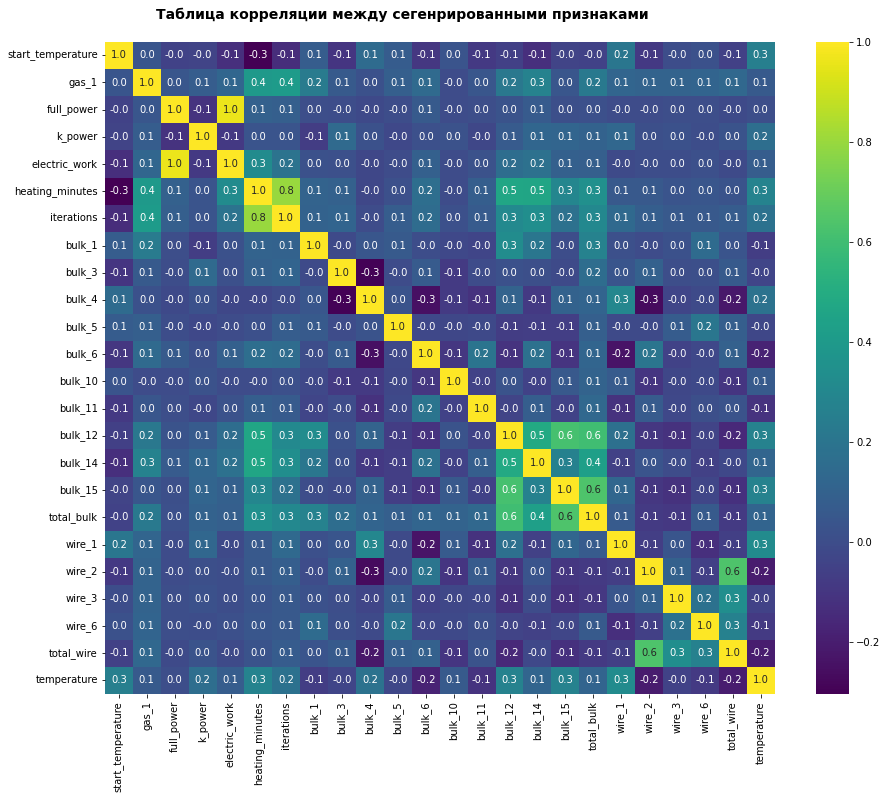

In [49]:
plt.figure(figsize = (15, 12))
sns.heatmap(data=df.corr(), annot=True, fmt='0.1f', cmap='viridis')
plt.suptitle(f'Таблица корреляции между сегенрированными признаками', 
             fontweight='bold',
             fontsize = 14,
             y = 0.92, x=0.4)
plt.show()

Абсолютная корреляция наблюдается между признаками electric_work и full_power, и на уровне 0,8 между iterations и heating_minutes временем нагревания. Удалим признак full_power, т.к. у него 0 корреляция с целевым признаком. Остальные признаки оценим по важности.

In [50]:
df = df.drop(['full_power'], axis=1)
df.sample()

,start_temperature,gas_1,k_power,electric_work,heating_minutes,iterations,bulk_1,bulk_3,bulk_4,bulk_5,bulk_6,bulk_10,bulk_11,bulk_12,bulk_14,bulk_15,total_bulk,wire_1,wire_2,wire_3,wire_6,total_wire,temperature
key,,,,,,,,,,,,,,,,,,,,,,,
406,1574.0,13.59,0.826,15.852,13.0,4,0.0,0.0,23.0,0.0,0.0,0.0,0.0,206.0,150.0,154.0,4,136.375,70.062,277.045,0.0,3,1585.0


In [51]:
mask_col = df[df.columns.difference(['temperature'])].columns 
df[mask_col]

,bulk_1,bulk_10,bulk_11,bulk_12,bulk_14,bulk_15,bulk_3,bulk_4,bulk_5,bulk_6,electric_work,gas_1,heating_minutes,iterations,k_power,start_temperature,total_bulk,total_wire,wire_1,wire_2,wire_3,wire_6
key,,,,,,,,,,,,,,,,,,,,,,
2499,0.0,0.0,0.0,233.0,126.0,227.0,47.0,0.0,0.0,0.0,21.697,11.336,14.717,4,0.829,1569.0,4,2,110.161,50.005,0.0,0.0
2498,0.0,101.0,0.0,206.0,129.0,207.0,90.0,0.0,0.0,0.0,12.797,14.954,12.500,5,0.827,1591.0,5,1,118.111,0.000,0.0,0.0
2497,0.0,0.0,0.0,230.0,124.0,226.0,0.0,85.0,0.0,0.0,9.282,6.272,9.483,3,0.766,1571.0,4,2,94.087,9.048,0.0,0.0
2496,0.0,122.0,0.0,256.0,129.0,226.0,0.0,63.0,0.0,0.0,14.588,9.413,15.667,6,0.830,1554.0,5,1,114.180,0.000,0.0,0.0
2495,0.0,90.0,0.0,256.0,129.0,223.0,21.0,0.0,0.0,0.0,12.980,7.126,12.050,4,0.807,1570.0,5,1,89.151,0.000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5,0.0,0.0,0.0,203.0,151.0,152.0,0.0,78.0,0.0,0.0,19.986,5.414,14.483,4,0.828,1576.0,4,2,89.238,9.115,0.0,0.0
4,0.0,0.0,0.0,207.0,153.0,154.0,0.0,81.0,0.0,0.0,13.282,18.841,12.350,4,0.842,1601.0,4,1,89.064,0.000,0.0,0.0
3,0.0,0.0,0.0,205.0,152.0,153.0,0.0,34.0,0.0,0.0,8.751,28.555,10.917,5,0.845,1596.0,4,1,91.160,0.000,0.0,0.0


In [52]:
#масштабируем признаки
df_scaler = df[mask_col]
scaler = StandardScaler()
df_scaler[mask_col] = scaler.fit_transform(df[mask_col])
display(df_scaler.head())

,bulk_1,bulk_10,bulk_11,bulk_12,bulk_14,bulk_15,bulk_3,bulk_4,bulk_5,bulk_6,electric_work,gas_1,heating_minutes,iterations,k_power,start_temperature,total_bulk,total_wire,wire_1,wire_2,wire_3,wire_6
key,,,,,,,,,,,,,,,,,,,,,,
2499,-0.276,-0.242,-0.189,0.157,-0.342,1.265,-0.005,-0.636,-0.118,-0.402,0.211,-0.006,0.221,-0.433,0.851,-0.626,0.333,1.068,0.177,0.964,-0.116,-0.113
2498,-0.276,4.588,-0.189,-0.015,-0.305,1.029,0.566,-0.636,-0.118,-0.402,-0.098,0.560,-0.169,0.190,0.779,0.151,1.149,-0.704,0.360,-0.524,-0.116,-0.113
2497,-0.276,-0.242,-0.189,0.137,-0.367,1.253,-0.629,0.814,-0.118,-0.402,-0.220,-0.799,-0.700,-1.056,-1.093,-0.556,0.333,1.068,-0.192,-0.255,-0.116,-0.113
2496,-0.276,5.592,-0.189,0.303,-0.305,1.253,-0.629,0.438,-0.118,-0.402,-0.035,-0.307,0.388,0.812,0.881,-1.157,1.149,-0.704,0.270,-0.524,-0.116,-0.113
2495,-0.276,4.062,-0.189,0.303,-0.305,1.218,-0.350,-0.636,-0.118,-0.402,-0.091,-0.665,-0.248,-0.433,0.186,-0.591,1.149,-0.704,-0.305,-0.524,-0.116,-0.113


In [53]:
%%time
#оценим важность при помощи к ближайщих соседей
sel_mut = SelectKBest(mutual_info_regression, k=5).fit(df_scaler, df.temperature)
display(pd.DataFrame(data =[sel_mut.get_support()], columns=df_scaler.columns))

,bulk_1,bulk_10,bulk_11,bulk_12,bulk_14,bulk_15,bulk_3,bulk_4,bulk_5,bulk_6,electric_work,gas_1,heating_minutes,iterations,k_power,start_temperature,total_bulk,total_wire,wire_1,wire_2,wire_3,wire_6
0,False,False,False,True,False,True,False,False,False,True,False,False,False,False,False,True,False,False,True,False,False,False


CPU times: user 295 ms, sys: 360 µs, total: 295 ms
Wall time: 295 ms


In [54]:
%%time
#оценим взаимную информацию между случайнми величинами 
mut_info = mutual_info_regression(df_scaler, df.temperature)
mut_info = pd.Series(mut_info, index=df_scaler.columns).sort_values(ascending=False)


CPU times: user 228 ms, sys: 3.38 ms, total: 232 ms
Wall time: 231 ms


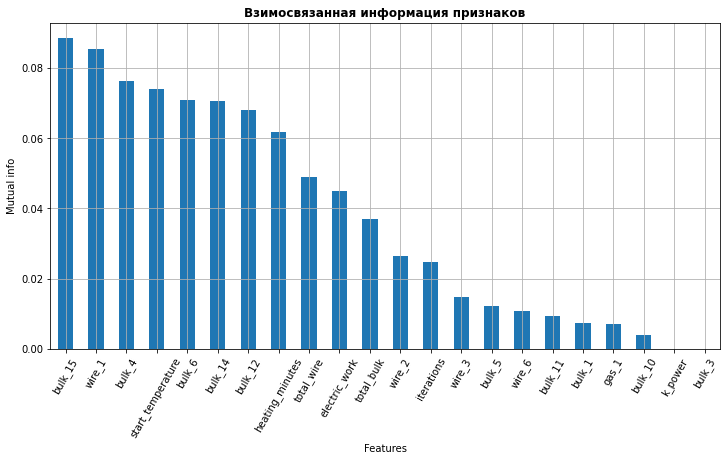

In [55]:
plt.figure(figsize = (12, 6))
plot_helper(mut_info, 
            x_title='Features', 
            y_title='Mutual info', 
            title='Взимосвязанная информация признаков', 
            type_plot='bar')
plt.show()

Значительное влияние на температуру оказывает `bulk_15`, `wire_1`, `start_temperature` и `bulk_15`. Наименее информативные признаки удалим.

In [56]:
df = df.drop(['k_power', 'bulk_3'], axis=1)
df.sample()

,start_temperature,gas_1,electric_work,heating_minutes,iterations,bulk_1,bulk_4,bulk_5,bulk_6,bulk_10,bulk_11,bulk_12,bulk_14,bulk_15,total_bulk,wire_1,wire_2,wire_3,wire_6,total_wire,temperature
key,,,,,,,,,,,,,,,,,,,,,
2243,1580.0,10.967,11.888,11.383,4,0.0,0.0,0.0,0.0,0.0,0.0,510.0,197.0,0.0,2,58.051,0.0,0.0,0.0,1,1585.0


### Разделение выборки

In [57]:
X_train, X_test, y_train, y_test = train_test_split(df[df.columns.difference(['temperature'])], 
                                                    df.temperature, 
                                                    test_size=0.25, 
                                                    random_state=STATE)

In [58]:
display(pd.DataFrame(
    {'sample_type':['test_sample', 'train_sample'],
     'target': [y_test.shape[0], 
                y_train.shape[0]], 
     'features': [X_test.shape[0],
                  X_train.shape[0]],
     'share': [y_test.shape[0] / df.shape[0], 
               y_train.shape[0] / df.shape[0]]
    }))

,sample_type,target,features,share
0,test_sample,583,583,0.25
1,train_sample,1746,1746,0.75


## Построение и обучение моделей

Для лучше интерпретации результатов обучения и тестирования моделей будем использовать метрику для задачи регрессии `MAE`.

Оценивать модель будем по следующим критериям оценки:

- Плохо | MAE > 6.8 |
- Нормально | 6.3 < MAE ≤ 6.8 |
- Хорошо | 6.0 < MAE ≤ 6.3 |
- Отлично | MAE ≤ 6.0 |

### Подбор параметров и обучение ML моделей

In [59]:
#функция для получения модели
def find_model(regressor, feature, target, param={}):
    pipe = Pipeline([('scaler', StandardScaler()), ('model', regressor)])
    clf = GridSearchCV(
        estimator=pipe, 
        param_grid = param, 
        cv = 5, 
        n_jobs=-1,
        scoring= 'neg_mean_absolute_error')    
    
    clf.fit(feature, target)
    
    print(f'Лчшие параметры {clf.best_params_,}\n')
    print(f'{regressor.__class__.__name__} train MAE:', -1 * clf.best_score_)
    
    res = [regressor.__class__.__name__, clf.best_score_ * -1]   
    
    return clf.best_estimator_, res

In [60]:
df_res = pd.DataFrame(columns=['model', 'mae'])
display(df_res)

,model,mae


In [61]:
model_linear, df_res.loc[len(df_res.index )] = find_model(LinearRegression(), X_train, y_train)
model_linear

Лчшие параметры ({},)

LinearRegression train MAE: 6.515972875977217


Pipeline(steps=[('scaler', StandardScaler()), ('model', LinearRegression())])

In [62]:
df_res

,model,mae
0,LinearRegression,6.516


In [63]:
%%time
lgbm_params = {
    'model__n_estimators': [140, 150, 160],
    'model__max_depth': [3, 4, 5],
    'model__min_child_samples': [2, 3, 4],
    'model__num_leaves': [13, 15, 20],
    'model__learning_rate': [0.05, 0.07, 0.08] 
}
model_lgbm, df_res.loc[len(df_res.index )] = find_model(LGBMRegressor(random_state=STATE), 
                                                X_train, 
                                                y_train, 
                                                lgbm_params)
model_lgbm

Лчшие параметры ({'model__learning_rate': 0.07, 'model__max_depth': 4, 'model__min_child_samples': 3, 'model__n_estimators': 150, 'model__num_leaves': 15},)

LGBMRegressor train MAE: 6.011964499055393
CPU times: user 2.91 s, sys: 407 ms, total: 3.31 s
Wall time: 40.8 s


Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 LGBMRegressor(learning_rate=0.07, max_depth=4,
                               min_child_samples=3, n_estimators=150,
                               num_leaves=15,
                               random_state=RandomState(MT19937) at 0x7F66A6069B40))])

In [64]:
df_res

,model,mae
0,LinearRegression,6.516
1,LGBMRegressor,6.012


In [65]:
%%time
catboost_params = {
    'model__learning_rate': [0.1, 0.05, 0.07],
    'model__iterations': [700, 800, 900],
    'model__max_depth': [3, 4, 5]
}
model_cat, df_res.loc[len(df_res.index )] = find_model(CatBoostRegressor(loss_function='MAE',
                                                                         bootstrap_type='Bernoulli', 
                                                                         subsample=0.7, 
                                                                         l2_leaf_reg=20, 
                                                                         boosting_type = 'Ordered',
                                                                         verbose=100), 
                                                       X_train, y_train, catboost_params)
model_cat

0:	learn: 8.0647554	total: 73.1ms	remaining: 51.1s
100:	learn: 5.5303724	total: 1.02s	remaining: 6.04s
200:	learn: 5.0852007	total: 1.68s	remaining: 4.17s
300:	learn: 4.8386601	total: 2.41s	remaining: 3.2s
400:	learn: 4.6561652	total: 2.99s	remaining: 2.23s
500:	learn: 4.5180946	total: 3.46s	remaining: 1.37s
600:	learn: 4.3768868	total: 3.98s	remaining: 656ms
699:	learn: 4.2795326	total: 4.66s	remaining: 0us
0:	learn: 7.9082309	total: 2.6ms	remaining: 1.82s
100:	learn: 5.5652348	total: 897ms	remaining: 5.32s
200:	learn: 5.1904200	total: 1.44s	remaining: 3.58s
300:	learn: 4.9635023	total: 1.94s	remaining: 2.58s
400:	learn: 4.7977956	total: 2.48s	remaining: 1.85s
500:	learn: 4.6687286	total: 3s	remaining: 1.19s
600:	learn: 4.5357059	total: 3.8s	remaining: 625ms
699:	learn: 4.4358612	total: 4.48s	remaining: 0us
0:	learn: 7.8266275	total: 6.14ms	remaining: 4.29s
100:	learn: 5.2854982	total: 922ms	remaining: 5.47s
200:	learn: 4.7150540	total: 2.27s	remaining: 5.63s
300:	learn: 4.3859133	tot

0:	learn: 7.8853963	total: 53.8ms	remaining: 37.6s
100:	learn: 5.5691962	total: 999ms	remaining: 5.92s
200:	learn: 5.1411912	total: 1.84s	remaining: 4.56s
300:	learn: 4.8894725	total: 2.74s	remaining: 3.64s
400:	learn: 4.6968933	total: 3.47s	remaining: 2.59s
500:	learn: 4.5591440	total: 4.2s	remaining: 1.67s
600:	learn: 4.4488678	total: 4.69s	remaining: 772ms
699:	learn: 4.3411715	total: 5.41s	remaining: 0us
0:	learn: 7.7908365	total: 21.8ms	remaining: 15.2s
100:	learn: 5.1936062	total: 780ms	remaining: 4.63s
200:	learn: 4.6676590	total: 1.76s	remaining: 4.38s
300:	learn: 4.3616521	total: 2.65s	remaining: 3.51s
400:	learn: 4.1065039	total: 3.74s	remaining: 2.79s
500:	learn: 3.9431984	total: 5.02s	remaining: 2s
600:	learn: 3.8005434	total: 6.62s	remaining: 1.09s
699:	learn: 3.6765477	total: 7.79s	remaining: 0us
0:	learn: 8.0565176	total: 7.07ms	remaining: 4.94s
100:	learn: 4.9944989	total: 1.65s	remaining: 9.8s
200:	learn: 4.3556941	total: 3.47s	remaining: 8.61s
300:	learn: 3.9931017	to

100:	learn: 5.4081516	total: 1.77s	remaining: 12.2s
200:	learn: 4.8878595	total: 3.45s	remaining: 10.3s
300:	learn: 4.5240970	total: 5.16s	remaining: 8.56s
400:	learn: 4.2661655	total: 7.39s	remaining: 7.35s
500:	learn: 4.0457735	total: 9.38s	remaining: 5.6s
600:	learn: 3.8654002	total: 10.9s	remaining: 3.62s
700:	learn: 3.7146023	total: 12.3s	remaining: 1.73s
799:	learn: 3.5831743	total: 13.7s	remaining: 0us
0:	learn: 8.0891681	total: 10.2ms	remaining: 8.15s
100:	learn: 5.7611409	total: 652ms	remaining: 4.51s
200:	learn: 5.3014859	total: 1.33s	remaining: 3.97s
300:	learn: 5.0588755	total: 1.91s	remaining: 3.17s
400:	learn: 4.9117955	total: 2.63s	remaining: 2.61s
500:	learn: 4.7777516	total: 3.4s	remaining: 2.03s
600:	learn: 4.6551132	total: 4.45s	remaining: 1.47s
700:	learn: 4.5504086	total: 5.16s	remaining: 729ms
799:	learn: 4.4641744	total: 5.69s	remaining: 0us
0:	learn: 7.7372073	total: 4.84ms	remaining: 3.87s
100:	learn: 5.6763276	total: 801ms	remaining: 5.54s
200:	learn: 5.192321

100:	learn: 5.7795658	total: 299ms	remaining: 2.36s
200:	learn: 5.3058906	total: 512ms	remaining: 1.78s
300:	learn: 5.0363575	total: 714ms	remaining: 1.42s
400:	learn: 4.8396892	total: 932ms	remaining: 1.16s
500:	learn: 4.6981123	total: 1.21s	remaining: 967ms
600:	learn: 4.5509736	total: 1.5s	remaining: 747ms
700:	learn: 4.4349431	total: 1.74s	remaining: 493ms
800:	learn: 4.3351061	total: 2s	remaining: 248ms
899:	learn: 4.2384539	total: 2.47s	remaining: 0us
Лчшие параметры ({'model__iterations': 900, 'model__learning_rate': 0.05, 'model__max_depth': 4},)

CatBoostRegressor train MAE: 5.969313769700877
CPU times: user 7.56 s, sys: 442 ms, total: 8 s
Wall time: 5min 25s


Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 <catboost.core.CatBoostRegressor object at 0x7f66a60f1c40>)])

In [66]:
df_res

,model,mae
0,LinearRegression,6.516
1,LGBMRegressor,6.012
2,CatBoostRegressor,5.969


### Обучение на многослойной нейросети

In [67]:
#Нормализуем данные для модели
normalizer = keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(df[df.columns.difference(['temperature'])]))
print(normalizer.mean.numpy())

2023-02-21 10:40:11.435433: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-02-21 10:40:11.436641: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (localadmin-Aspire-A315-56): /proc/driver/nvidia/version does not exist
2023-02-21 10:40:11.442468: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[[3.42765236e+00 5.05281258e+00 4.24516964e+00 2.08415649e+02
  1.53853561e+02 1.19952774e+02 3.73035622e+01 2.64018917e+00
  2.24302273e+01 1.56064396e+01 1.13755989e+01 1.34607944e+01
  4.69557762e+00 1.58671887e+03 3.59295845e+00 1.39716625e+00
  1.02443619e+02 1.76098652e+01 3.23491573e+00 9.78820086e-01]]


In [68]:
#Проверяем нормализацию
first = np.array(df[df.columns.difference(['temperature'])][:1])

with np.printoptions(precision=2):
    print('Первый пример:', first)
    print()
    print('Нормализованный:', normalizer(first).numpy())

Первый пример: [[   0.      0.      0.    233.    126.    227.      0.      0.      0.
    21.7    11.34   14.72    4.   1569.      4.      2.    110.16   50.01
     0.      0.  ]]

Нормализованный: [[-0.28 -0.24 -0.19  0.16 -0.34  1.27 -0.64 -0.12 -0.4   0.21 -0.01  0.22
  -0.43 -0.63  0.33  1.07  0.18  0.96 -0.12 -0.11]]


In [69]:
#получим модель нейроной сети
def get_neural_model(norm, n_outputs, lr=0.01):
    model = Sequential()
    model.add(norm)
    model.add(Dense(256, kernel_regularizer=keras.regularizers.l2(0.01), activation='relu'))
    model.add(Dense(128, kernel_regularizer=keras.regularizers.l2(0.01), activation='relu'))
    model.add(Dense(128, kernel_regularizer=keras.regularizers.l2(0.01), activation='relu'))
    model.add(Dense(n_outputs))
    model.compile(loss='mae', optimizer=keras.optimizers.Adam(lr))
    return model

In [70]:
model_net = get_neural_model(normalizer, 1, 0.000557)
model_net.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 20)               41        
 n)                                                              
                                                                 
 dense (Dense)               (None, 256)               5376      
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 54,954
Trainable params: 54,913
Non-trainable params: 41
___________________________________________________

In [71]:
%%time
hist = model_net.fit(X_train, y_train, batch_size=4, validation_split=0.2, verbose=50, epochs=2500)

Epoch 1/2500
Epoch 2/2500
Epoch 3/2500
Epoch 4/2500
Epoch 5/2500
Epoch 6/2500
Epoch 7/2500
Epoch 8/2500
Epoch 9/2500
Epoch 10/2500
Epoch 11/2500
Epoch 12/2500
Epoch 13/2500
Epoch 14/2500
Epoch 15/2500
Epoch 16/2500
Epoch 17/2500
Epoch 18/2500
Epoch 19/2500
Epoch 20/2500
Epoch 21/2500
Epoch 22/2500
Epoch 23/2500
Epoch 24/2500
Epoch 25/2500
Epoch 26/2500
Epoch 27/2500
Epoch 28/2500
Epoch 29/2500
Epoch 30/2500
Epoch 31/2500
Epoch 32/2500
Epoch 33/2500
Epoch 34/2500
Epoch 35/2500
Epoch 36/2500
Epoch 37/2500
Epoch 38/2500
Epoch 39/2500
Epoch 40/2500
Epoch 41/2500
Epoch 42/2500
Epoch 43/2500
Epoch 44/2500
Epoch 45/2500
Epoch 46/2500
Epoch 47/2500
Epoch 48/2500
Epoch 49/2500
Epoch 50/2500
Epoch 51/2500
Epoch 52/2500
Epoch 53/2500
Epoch 54/2500
Epoch 55/2500
Epoch 56/2500
Epoch 57/2500
Epoch 58/2500
Epoch 59/2500
Epoch 60/2500
Epoch 61/2500
Epoch 62/2500
Epoch 63/2500
Epoch 64/2500
Epoch 65/2500
Epoch 66/2500
Epoch 67/2500
Epoch 68/2500
Epoch 69/2500
Epoch 70/2500
Epoch 71/2500
Epoch 72/2500
E

Epoch 444/2500
Epoch 445/2500
Epoch 446/2500
Epoch 447/2500
Epoch 448/2500
Epoch 449/2500
Epoch 450/2500
799:	learn: 3.7192452	total: 13.6s	remaining: 0us
0:	learn: 7.9483884	total: 6.75ms	remaining: 5.39s
100:	learn: 5.5945826	total: 1.61s	remaining: 11.1s
200:	learn: 5.0465558	total: 2.9s	remaining: 8.65s
300:	learn: 4.7106485	total: 4.9s	remaining: 8.12s
400:	learn: 4.4398066	total: 6.65s	remaining: 6.62s
500:	learn: 4.2369965	total: 8.43s	remaining: 5.03s
600:	learn: 4.0670303	total: 10.1s	remaining: 3.33s
700:	learn: 3.9250469	total: 11.6s	remaining: 1.64s
799:	learn: 3.7903322	total: 13.5s	remaining: 0us
0:	learn: 7.7329482	total: 2.17ms	remaining: 1.74s
100:	learn: 5.3862517	total: 1.38s	remaining: 9.57s
200:	learn: 4.8507376	total: 2.63s	remaining: 7.84s
300:	learn: 4.5598726	total: 3.94s	remaining: 6.54s
400:	learn: 4.3536584	total: 4.87s	remaining: 4.85s
500:	learn: 4.1786893	total: 6.23s	remaining: 3.72s
600:	learn: 4.0284223	total: 7.63s	remaining: 2.53s
700:	learn: 3.91391

Epoch 451/2500
Epoch 452/2500
700:	learn: 4.5653093	total: 5s	remaining: 706ms
799:	learn: 4.4646063	total: 5.95s	remaining: 0us
0:	learn: 7.8347163	total: 10.6ms	remaining: 8.5s
100:	learn: 5.4947355	total: 1.43s	remaining: 9.88s
200:	learn: 4.9630170	total: 2.74s	remaining: 8.17s
300:	learn: 4.6369778	total: 4.11s	remaining: 6.81s
400:	learn: 4.4087650	total: 5.07s	remaining: 5.04s
500:	learn: 4.2087148	total: 5.95s	remaining: 3.55s
600:	learn: 4.0471988	total: 7.15s	remaining: 2.37s
700:	learn: 3.9216334	total: 8.04s	remaining: 1.14s
799:	learn: 3.8245153	total: 9.15s	remaining: 0us
0:	learn: 8.0834016	total: 30.2ms	remaining: 24.1s
100:	learn: 5.3321133	total: 1.86s	remaining: 12.9s
200:	learn: 4.6968667	total: 3.54s	remaining: 10.5s
300:	learn: 4.3094296	total: 6.1s	remaining: 10.1s
400:	learn: 4.0235219	total: 15.6s	remaining: 15.6s
500:	learn: 3.7952000	total: 18s	remaining: 10.8s
600:	learn: 3.6353767	total: 20.4s	remaining: 6.78s
700:	learn: 3.5186906	total: 22.8s	remaining: 3

Epoch 555/2500
Epoch 556/2500
Epoch 557/2500
Epoch 558/2500
Epoch 559/2500
Epoch 560/2500
Epoch 561/2500
Epoch 562/2500
Epoch 563/2500
Epoch 564/2500
Epoch 565/2500
Epoch 566/2500
Epoch 567/2500
Epoch 568/2500
Epoch 569/2500
Epoch 570/2500
Epoch 571/2500
Epoch 572/2500
Epoch 573/2500
Epoch 574/2500
Epoch 575/2500
Epoch 576/2500
Epoch 577/2500
Epoch 578/2500
Epoch 579/2500
Epoch 580/2500
Epoch 581/2500
Epoch 582/2500
Epoch 583/2500
Epoch 584/2500
Epoch 585/2500
Epoch 586/2500
Epoch 587/2500
Epoch 588/2500
Epoch 589/2500
Epoch 590/2500
Epoch 591/2500
Epoch 592/2500
Epoch 593/2500
Epoch 594/2500
Epoch 595/2500
Epoch 596/2500
Epoch 597/2500
Epoch 598/2500
Epoch 599/2500
Epoch 600/2500
Epoch 601/2500
Epoch 602/2500
Epoch 603/2500
Epoch 604/2500
Epoch 605/2500
Epoch 606/2500
Epoch 607/2500
Epoch 608/2500
Epoch 609/2500
Epoch 610/2500
Epoch 611/2500
Epoch 612/2500
Epoch 613/2500
Epoch 614/2500
Epoch 615/2500
Epoch 616/2500
Epoch 617/2500
Epoch 618/2500
Epoch 619/2500
Epoch 620/2500
Epoch 621/

Epoch 1095/2500
Epoch 1096/2500
Epoch 1097/2500
Epoch 1098/2500
Epoch 1099/2500
Epoch 1100/2500
Epoch 1101/2500
Epoch 1102/2500
Epoch 1103/2500
Epoch 1104/2500
Epoch 1105/2500
Epoch 1106/2500
Epoch 1107/2500
Epoch 1108/2500
Epoch 1109/2500
Epoch 1110/2500
Epoch 1111/2500
Epoch 1112/2500
Epoch 1113/2500
Epoch 1114/2500
Epoch 1115/2500
Epoch 1116/2500
Epoch 1117/2500
Epoch 1118/2500
Epoch 1119/2500
Epoch 1120/2500
Epoch 1121/2500
Epoch 1122/2500
Epoch 1123/2500
Epoch 1124/2500
Epoch 1125/2500
Epoch 1126/2500
Epoch 1127/2500
Epoch 1128/2500
Epoch 1129/2500
Epoch 1130/2500
Epoch 1131/2500
Epoch 1132/2500
Epoch 1133/2500
Epoch 1134/2500
Epoch 1135/2500
Epoch 1136/2500
Epoch 1137/2500
Epoch 1138/2500
Epoch 1139/2500
Epoch 1140/2500
Epoch 1141/2500
Epoch 1142/2500
Epoch 1143/2500
Epoch 1144/2500
Epoch 1145/2500
Epoch 1146/2500
Epoch 1147/2500
Epoch 1148/2500
Epoch 1149/2500
Epoch 1150/2500
Epoch 1151/2500
Epoch 1152/2500
Epoch 1153/2500
Epoch 1154/2500
Epoch 1155/2500
Epoch 1156/2500
Epoch 11

Epoch 1608/2500
Epoch 1609/2500
Epoch 1610/2500
Epoch 1611/2500
Epoch 1612/2500
Epoch 1613/2500
Epoch 1614/2500
Epoch 1615/2500
Epoch 1616/2500
Epoch 1617/2500
Epoch 1618/2500
Epoch 1619/2500
Epoch 1620/2500
Epoch 1621/2500
Epoch 1622/2500
Epoch 1623/2500
Epoch 1624/2500
Epoch 1625/2500
Epoch 1626/2500
Epoch 1627/2500
Epoch 1628/2500
Epoch 1629/2500
Epoch 1630/2500
Epoch 1631/2500
Epoch 1632/2500
Epoch 1633/2500
Epoch 1634/2500
Epoch 1635/2500
Epoch 1636/2500
Epoch 1637/2500
Epoch 1638/2500
Epoch 1639/2500
Epoch 1640/2500
Epoch 1641/2500
Epoch 1642/2500
Epoch 1643/2500
Epoch 1644/2500
Epoch 1645/2500
Epoch 1646/2500
Epoch 1647/2500
Epoch 1648/2500
Epoch 1649/2500
Epoch 1650/2500
Epoch 1651/2500
Epoch 1652/2500
Epoch 1653/2500
Epoch 1654/2500
Epoch 1655/2500
Epoch 1656/2500
Epoch 1657/2500
Epoch 1658/2500
Epoch 1659/2500
Epoch 1660/2500
Epoch 1661/2500
Epoch 1662/2500
Epoch 1663/2500
Epoch 1664/2500
Epoch 1665/2500
Epoch 1666/2500
Epoch 1667/2500
Epoch 1668/2500
Epoch 1669/2500
Epoch 16

Epoch 2121/2500
Epoch 2122/2500
Epoch 2123/2500
Epoch 2124/2500
Epoch 2125/2500
Epoch 2126/2500
Epoch 2127/2500
Epoch 2128/2500
Epoch 2129/2500
Epoch 2130/2500
Epoch 2131/2500
Epoch 2132/2500
Epoch 2133/2500
Epoch 2134/2500
Epoch 2135/2500
Epoch 2136/2500
Epoch 2137/2500
Epoch 2138/2500
Epoch 2139/2500
Epoch 2140/2500
Epoch 2141/2500
Epoch 2142/2500
Epoch 2143/2500
Epoch 2144/2500
Epoch 2145/2500
Epoch 2146/2500
Epoch 2147/2500
Epoch 2148/2500
Epoch 2149/2500
Epoch 2150/2500
Epoch 2151/2500
Epoch 2152/2500
Epoch 2153/2500
Epoch 2154/2500
Epoch 2155/2500
Epoch 2156/2500
Epoch 2157/2500
Epoch 2158/2500
Epoch 2159/2500
Epoch 2160/2500
Epoch 2161/2500
Epoch 2162/2500
Epoch 2163/2500
Epoch 2164/2500
Epoch 2165/2500
Epoch 2166/2500
Epoch 2167/2500
Epoch 2168/2500
Epoch 2169/2500
Epoch 2170/2500
Epoch 2171/2500
Epoch 2172/2500
Epoch 2173/2500
Epoch 2174/2500
Epoch 2175/2500
Epoch 2176/2500
Epoch 2177/2500
Epoch 2178/2500
Epoch 2179/2500
Epoch 2180/2500
Epoch 2181/2500
Epoch 2182/2500
Epoch 21

In [72]:
df_hist = pd.DataFrame(hist.history)
display(df_hist.tail())

,loss,val_loss
2495,7.631,11.838
2496,7.679,9.357
2497,7.952,10.662
2498,8.099,10.091
2499,7.735,9.769


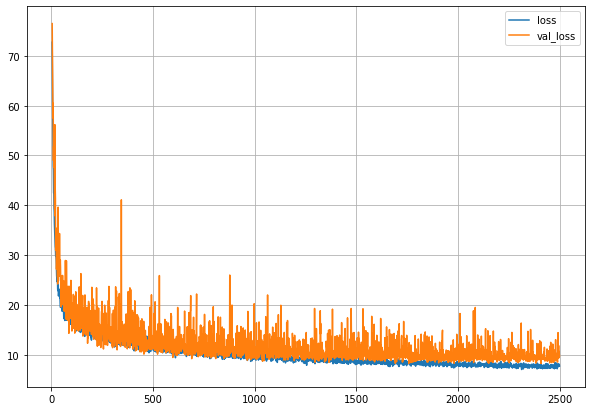

In [73]:
plt.figure(figsize = (10, 7))
plot_helper(df_hist, type_plot='plot')

In [74]:
model_net.evaluate(X_train, y_train, verbose=0)

7.896990776062012

In [75]:
df_res.loc[len(df_res.index )] = ['NeuronNet', model_net.evaluate(X_train, y_train, verbose=0)]
df_res

,model,mae
0,LinearRegression,6.516
1,LGBMRegressor,6.012
2,CatBoostRegressor,5.969
3,NeuronNet,7.897


In [76]:
#обучениеи получение результата на константной модели
dummy_model, df_res.loc[len(df_res.index )] = find_model(DummyRegressor(strategy='mean'), X_train, y_train)
dummy_model

Лчшие параметры ({},)

DummyRegressor train MAE: 8.004012585298417


Pipeline(steps=[('scaler', StandardScaler()), ('model', DummyRegressor())])

### Определение лучшей модели

In [77]:
df_res.T

,0,1,2,3,4
model,LinearRegression,LGBMRegressor,CatBoostRegressor,NeuronNet,DummyRegressor
mae,6.516,6.012,5.969,7.897,8.004


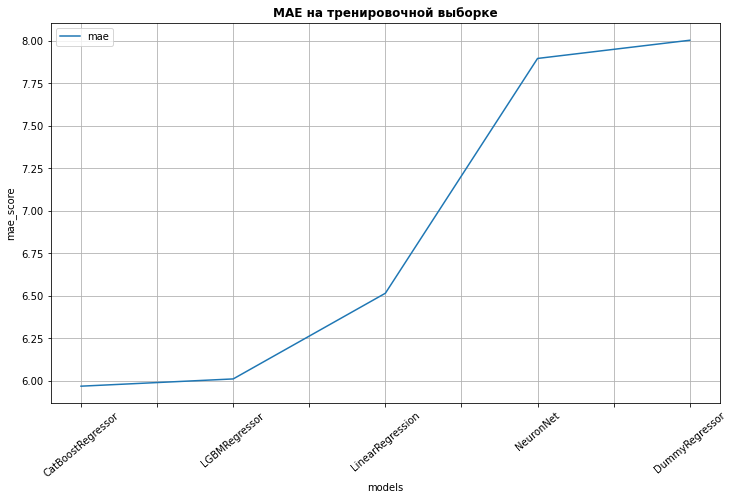

In [78]:
plt.figure(figsize=(12, 7))
plot_helper(df_res.set_index('model').sort_values('mae').mae,
           x_title='models',
           y_title='mae_score',
           title='MAE на тренировочной выборке',
           type_plot='line')
plt.show()

После подбора параметров и обучения моделей на тренировочной выборке, лучший результат показывает `CatBoost` с метрикой `MAE  5.969`. Константная модель `Dummy` показала результат ` MAE 8,004`, соотвественно все модели показывающий лучщи результат показывают более менее адекватный результат.

### Тестирование лучшей модели

In [79]:
cat_pred = model_cat.predict(X_test)
print('Тест CatBoostRegressor MAE -', mean_absolute_error(cat_pred, y_test))

Тест CatBoostRegressor MAE - 6.195112926876569


## Общий вывод

Данное исследование было реализовано с целью разработки модели для предсказания тепературы, что позволит улучшать технологические процессы и экономить средства на электроэнергии предприятию.  
В ходе исследования был проведен анализ данных, созданы и отобраны признаки для обучения модели, и произведен подбор праметров на оcновании результатов которых была выбрана лучша модель `CatBoostRegressor`. Лучшая модель протестирована на тестовой выборке и показала результат - `6,215`.

В ходе обучения модели выявились следующие признаки повлиявшие на результат работы модели:

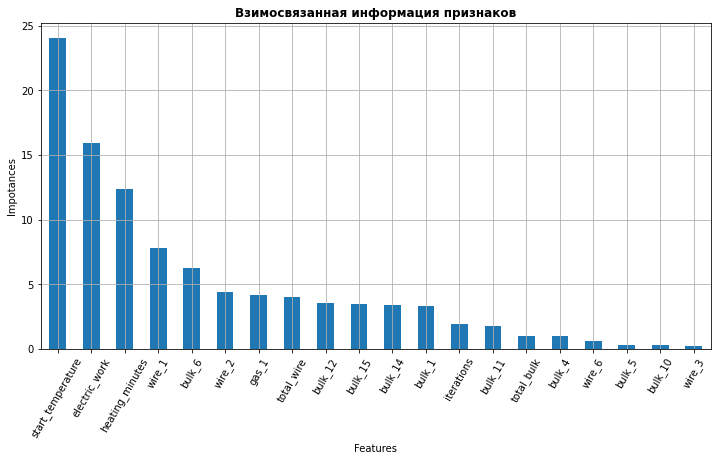

,features,importances
13,start_temperature,24.03
9,electric_work,15.91
11,heating_minutes,12.39
16,wire_1,7.80
8,bulk_6,6.30
17,wire_2,4.38
10,gas_1,4.17
15,total_wire,4.05
3,bulk_12,3.59
5,bulk_15,3.51


In [80]:
df_importances = pd.DataFrame(
    {'features' : X_train.columns,
     'importances' : np.round(model_cat[1].feature_importances_, 2)}
).sort_values(by='importances', ascending=False)


plt.figure(figsize = (12, 6))
plot_helper(data=df_importances.set_index('features').importances, 
            x_title='Features', 
            y_title='Impotances', 
            title='Взимосвязанная информация признаков', 
            type_plot='bar')
plt.show()
display(df_importances)

## Отчет

**Сравнение решения и плана проекта:**

В целом работа выполнена в соотвествии с разработанным ранее планом:

1. *Подготовить данные*          
2. *Провести исследовательский анализ данных*  
3. *Провести предобработку данных*   
4. *Формирование датасета для обучения моделей из исходных данных*        
5. *Построить и обучить модель*

Содержание текущего проекта отражает последовательность действий, анализа и исследования в соотвествии с ранее продуманым планом. Ислючение некоторые пункты из плана перешли в другие главы плана, т.к. в ходе исследовани и последовательности действи они оказались более лаконичны именно в этих главах, а не запланированных ранее.

**Описание трудностей проекта:**

В ходе выполнения проекта с основными сложностями с которыми столнкулся были:  
- рассинхронизация времени у разных таблиц;
- маленькое количество объектов, при большем количестве возможно получения более выскоих метрик
- подбор гипперпараметров и обучение ML моделей и особенно было сложно с обучением нейронной сети и добиться лучшего результата, чем у константной модели.  

В решении данных сложностей очень сильно помогла библиотека `sklearn`, и в частности модуль `GridSearchCV`. В остальном это потраченное время на подбор лучших параметров, и их перебор с помощью выщеупомянутого модуля.  
С нейроной сетью было сложнее, и практически параметры подбирались в ручную, без использования дополнительных методов подбора, осложнялось все маллым количество объектов для нейронной сети и отсутвие опыта работы с нейронными сетями.

**Ключевые шаги решения задачи в проекте:**  

- Получение данных и анализа их структуры и содержания.
- Анализ основных статистических показателей данных в таблицах, их распределение и возможные аномалии.
- Подготовка данных, выделение и удаление аномалий, проверка типов данных, обработка пропусков
- Выделениние целевого признака, и его анализ
- Выделение и создание признаков необходимых для дальнейшего обучения моделей, при необходимости их группировка и вычисления.
- Отбор важных признаков для обучение модели, с помощью исключения мультиколлинеарности признаков и модуля `SelectKBest` + `mutual_info_regression` из библиотеки `sklearn`.
- Выбор моделей и подбор лучших параметров с использование модулей `GridSearchCV` и `Pipeline`, кроссвалидации при обучении  моделей.
- Определение лучшей метрики на тренировочных данных, и выбор лучшей модели
- Тестирование лучшей модели и получение теребйемоц метрики на тестовой выборке

**Признаки которые использовались для обучения (и их предобработка)**  

В ходе исследования были созданыи отобраны следующие признаки:

In [81]:
list(df.columns)

['start_temperature',
 'gas_1',
 'electric_work',
 'heating_minutes',
 'iterations',
 'bulk_1',
 'bulk_4',
 'bulk_5',
 'bulk_6',
 'bulk_10',
 'bulk_11',
 'bulk_12',
 'bulk_14',
 'bulk_15',
 'total_bulk',
 'wire_1',
 'wire_2',
 'wire_3',
 'wire_6',
 'total_wire',
 'temperature']

Предобработка данных включала в себя:
- Проверка на наличие пропусков и замена пустых значений на требуеме значения. В частности в обеих таблицах
- Масштабирование признаков с использованием модуля `StandardScaler` из библиотеки `sklearn`.

**Итоговая модель и ее параметры:**  

В ходе исследования была построена и выбрана ML модель из семейства `catboost`, со следующими параметрами:

In [82]:
display(f'Лучшая модель - {model_cat[1].__class__.__name__}')
print('Полный список параметров:') 
display(pd.DataFrame(model_cat[1].get_all_params()).T)

'Лучшая модель - CatBoostRegressor'

Полный список параметров:


,tags
nan_mode,Min
eval_metric,MAE
iterations,900
sampling_frequency,PerTree
fold_permutation_block,0
leaf_estimation_method,Exact
grow_policy,SymmetricTree
penalties_coefficient,1
boosting_type,Ordered
model_shrink_mode,Constant


**Итоговая метрика лучшей модели CatBoostRegressor:** 

In [83]:
print(f'MAE {model_cat[1].__class__.__name__} - {mean_absolute_error(cat_pred, y_test)}')

MAE CatBoostRegressor - 6.195112926876569
